# **0. Setup : Set your Colab runtime type as 'T4 GPU'**

### 0.1 Clone Github Repository

In [6]:
!git clone https://github.com/chaeraemong/AI503-Final-Project.git

Cloning into 'AI503-Final-Project'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 120 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 436.64 KiB | 10.92 MiB/s, done.
Resolving deltas: 100% (9/9), done.


### 0.2 Setting up the environment with specific versions of packages

> **In order to get the fastest trainings you need to enable GPUs for the notebook(if needed):**
> * Navigate to Edit→Notebook Settings
> * Select GPU from the Hardware Accelerator drop-down(https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd)

In [7]:
!cd AI503-Final-Project; pip install -e .; cd -
!pip install tensorboard
!pip install nvidia-ml-py
!pip install gpytorch

Obtaining file:///content/AI503-Final-Project/AI503-Final-Project
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached black-24.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (77 kB)
  Using cached botorch-0.16.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached configspace-1.2.1.tar.gz (130 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached flake8_bugbear-25.11.29-py3-none-any.whl.metadata (35 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached pre_commit-4.5.0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached ruff_api-0.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cache

### 0.3 Import Packages

In [20]:
%cd AI503-Final-Project

try:
    import pfns
except ImportError:
    raise ImportError("[ ERROR ] Please restart the session!")

import os
import math
import torch
import sklearn.linear_model
import matplotlib.pyplot as plt

from torch import nn

from pfns import utils
from pfns import priors
from pfns.priors import Batch
from pfns.priors.prior import AdhocPriorConfig
from pfns.priors.fast_gp import get_batch as get_batch_for_gp
from pfns.model import bar_distribution
from pfns.model.encoders import EncoderConfig
from pfns.model.bar_distribution import BarDistributionConfig
from pfns.train import train, MainConfig, OptimizerConfig, TransformerConfig, BatchShapeSamplerConfig


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[ DEBUG ] Using device: {device}")

[Errno 2] No such file or directory: 'AI503-Final-Project'
/content/AI503-Final-Project/AI503-Final-Project
[ DEBUG ] Using device: cuda


---
# 1. Prior-Data Fitted Networks (PFNs)

<figure align="center">
    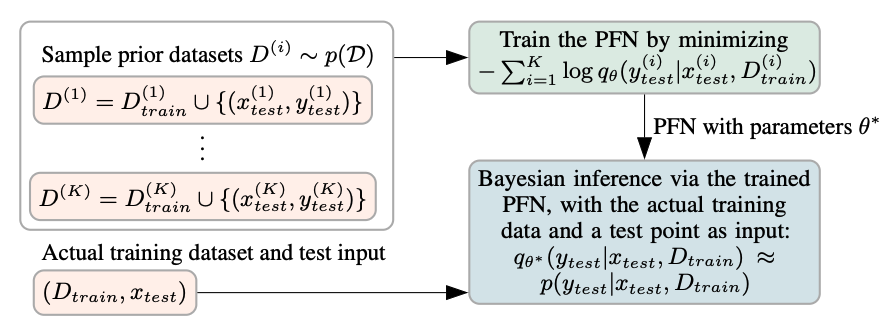
    <figcaption>
        Fig. 1. A visualization of Prior-Data Fitted Network (PFN).
    </figcaption>
</figure>

<!-- <p align="center">
  <img src="PFN_figure1.png" width="800">
</p>
<p align="center"><em>Fig. 1. A visualization of Prior-Data Fitted Network (PFN).</em></p> -->


Prior-Data Fitted Networks (PFNs), introduced in **Transformers Can Do Bayesian Inference**([arXiv:2112.10510](https://arxiv.org/pdf/2112.10510)), are neural networks trained **not on a single dataset**, but on **datasets sampled from a predefined prior**. The goal of a PFN is to approximate the **Bayesian posterior predictive distribution** (PPD) induced by that prior using a single feed-forward model.

Formally, given a prior over data-generating processes $p(D)$, a PFN learns a function

$$(x_*,D)\;\mapsto\;p(y_*\mid x_*,D),$$

without performing explicit inference at test time. A crucial requirement is therefore a **fully specified prior**. In this document, we focus on **Ridge Regression** as a canonical example and show how PFNs approximate its Bayesian posterior predictive.


---
---

# 2. Ridge Regression

Ridge regression is a regularized variant of linear regression that penalizes the squared $\ell_2$-norm of the coefficients. It admits both a **frequentist** and a **Bayesian** interpretation, with the latter being central to PFNs.


### 2.1 Frequentist Ridge Regression

- **Model**

    Let

  $$y=X\beta+\varepsilon,\quad\varepsilon\sim N(0,\sigma^2I),$$

    where $X\in\mathbb R^{n\times p}$, $y\in\mathbb R^n$, and $\beta\in\mathbb R^p$.

- **Objective**

    The ridge estimator is defined as

  $$\hat{\beta}_{\text{ridge}}=\arg\min_{\beta}\left(\|y-X\beta\|_2^2+\lambda\|\beta\|_2^2\right),$$

    where $\lambda\ge0$ controls the strength of regularization. As $\lambda$ increases, the coefficients are increasingly shrunk toward zero, improving stability at the cost of bias.

    ---

### 2.2 Bayesian Ridge Regression

- **Likelihood**

    Assume Gaussian observation noise:

  $$p(y\mid X,\beta)=N(X\beta,\sigma^2I).$$

- **Prior**

    Place a zero-mean isotropic Gaussian prior on the coefficients:
  $$p(\beta)=N(0,\tau^2I).$$

    This expresses a prior belief that large coefficients are unlikely.
    - $\tau^2$ : variance of the prior  
        - smaller $\tau^2$ → stronger belief that coefficients are near zero  

- **Posterior**

    By Bayes’ rule,
  $$p(\beta\mid X,y)\propto\exp\left(-\frac{1}{2\sigma^2}\|y-X\beta\|_2^2-\frac{1}{2\tau^2}\|\beta\|_2^2\right).$$

- **MAP Estimation**

    Maximizing the posterior is equivalent to minimizing
  $$\hat{\beta}_{\text{MAP}}=\arg\min_{\beta}\left(\frac{1}{\sigma^2}\|y-X\beta\|_2^2+\frac{1}{\tau^2}\|\beta\|_2^2\right).$$

    Identifying terms yields
  $$\boxed{\lambda=\frac{\sigma^2}{\tau^2}},$$
    showing that ridge regression corresponds exactly to **MAP estimation** in Bayesian linear regression.

    - **Stronger prior belief** ⇒ **larger $\lambda$** ⇒ **more shrinkage**
    - **Weaker prior belief** ⇒ **smaller $\lambda$** ⇒ **less shrinkage**

> Importantly, PFNs do **not** approximate the MAP estimator, but the **posterior predictive distribution**.


### Summary

| Concept | Frequentist View | Bayesian View |
|------|------------------|---------------|
| Objective | RSS $^*$ + L2 penalty | Negative log-posterior |
| Penalty | $\lambda\|\beta\|_2^2$ | Gaussian prior |
| Estimate | Ridge estimator | MAP estimator(not used by PFNs)|
| Interpretation | Regularization | Prior belief |

$^*$ RSS : Residual Sum of Squares

---
---

# 3. Examples

We now present **four concrete examples** that illustrate how PFNs behave under different priors and data-generating processes.

In all cases, datasets are sampled from a **known prior**, and a PFN is trained to approximate the corresponding **Bayesian posterior predictive distribution** induced by that prior. Each example highlights a different aspect of PFNs, ranging from analytically tractable settings to misspecified models.

Specifically, we consider:
1. **1D Linear Regression** — a simple, fully analyzable case closely related to ridge regression.
2. **Sine Curve Regression** — a nonlinear function family where exact Bayesian inference is intractable.
3. **Anti-Sine Regression** — a deliberately misspecified setting that probes robustness under prior mismatch.
4. **Gaussian Prior over Functions** — a function-space prior connecting PFNs to Gaussian Processes.

Together, these examples provide an intuitive and progressively richer understanding of how PFNs implement amortized Bayesian inference.

---

### 3.1 **1D Linear Regression**

Consider a one-dimensional linear function:
$$f(x) = wx+b.$$

- **Prior**

    $$w\sim N(0,\beta^2).$$
    For simplicity, we fix the bias term to $b=1$.

- **Likelihood**

    $$y\mid x,w\sim N(wx+b, \alpha^2).$$

- **Data Generation**

    For dataset $i=1,\dots,K$ and samples $j=1,\dots,N$ for each dataset:
    $$x_{ij}\sim\text{Uniform}(0,1),$$
    $$w_i\sim N(0,\beta^2),\quad b_i=1,$$
    $$\epsilon_{ij}\sim N(0,\alpha^2),$$
    $$y_{ij}|x_{ij},w_i\sim N(x_{ij}w_i+b_i, \alpha^2).$$

    For each dataset $i$,
    $$y_i|x_i,w_i\sim N(x_iw_i+b_i\mathbf 1, \alpha^2I)$$


> Each dataset corresponds to a different latent weight $w_i$. The PFN does not explicitly estimate $w_i$; instead, it implicitly marginalizes over it by conditioning on the observed context data.
> Given a set of context $(x,y)$ pairs, the PFN implements an amortized posterior predictive and produces predictions for new input locations $x$.
> During training, each dataset is automatically split into context and target sets, which are used to train the PFN to perform conditional prediction.


##### 3.1.1 Sample from prior

The code below samples multiple 1D regression datasets from a Gaussian prior over linear functions with additive Gaussian noise. Each dataset corresponds to a different latent weight vector drawn from the prior, with 100 data points sampled for each of the 10 datasets, and is used to train PFNs via prior-sampled data.

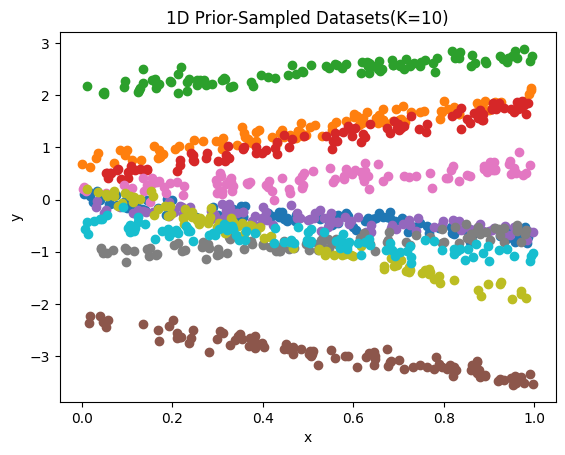

In [9]:
def sample_1D_prior_datasets(
    batch_size=10,
    seq_len=100,
    num_features=1,
    hyperparameters=None,
    device='cpu',
    **kwargs
):
    if hyperparameters is None:
        hyperparameters = {'a': 0.1, 'b': 1.0}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))    # (K, F+1)
    bs = torch.ones(batch_size, seq_len, 1)                                                                     # (K, N, 1)

    xs = torch.rand(batch_size, seq_len, num_features)                                                          # (K, N, F)
    ys = torch.distributions.Normal(torch.einsum('knf, kf -> kn', torch.cat([xs, bs], 2), ws), hyperparameters['a']).sample()[..., None]    # (K, N, F+1)∙(K, F+1) -> (K, N)

    return Batch(x=xs.to(device), y=ys.to(device), target_y=ys.to(device))  # return two different ys


K = 10          # number of datasets
N = 100         # number of data points in each dataset
F = 1           # number of features

alpha = 0.1     # noise variance
beta = 1.0      # prior variance

batch = sample_1D_prior_datasets(K, N, F, {'a': alpha, 'b': beta})
plt.figure()
for dataset_index in range(K):
    plt.scatter(batch.x[dataset_index,:,0].numpy(), batch.y[dataset_index].numpy())
plt.title(f"1D Prior-Sampled Datasets(K={dataset_index + 1})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

##### 3.1.2 Train PFN
We train a small PFN on 1D regression datasets containing up to 100 data points.
On a standard machine, this training procedure takes approximately one minute.

**What Happens During Training?**
<figure align="center">
    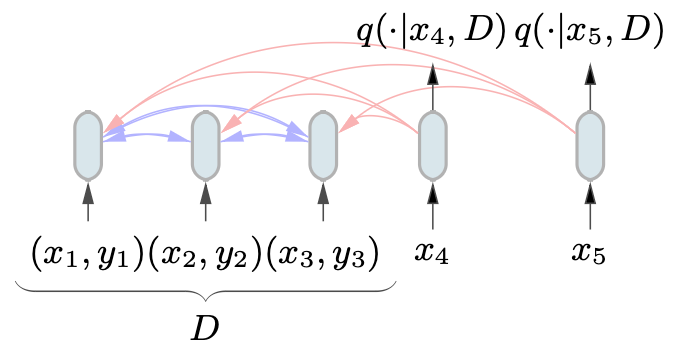
    <figcaption>
        Fig. 2. A visualization of the Transformer for n=3 input pairs and m=2 queries. Every bar is the representation of one input and the arrows show what each representation can attend to.
    </figcaption>
</figure>


During training, datasets are repeatedly sampled from the `sample_1D_prior_datasets` method.
Each sampled dataset is split into a context set and a target set according to a randomly chosen position called `single_eval_pos`, which is drawn uniformly at random.
- Data points to the left of `single_eval_pos` form the context(training) set.
- Data points to the right form the target(test) set.

The PFN is trained to predict the target outputs $y$ given:
- the context pairs $(x, y)$, and
- the target inputs $x$ only.

Training is performed using the Adam optimizer and a cross-entropy loss, corresponding to the discretized (Riemann) output distribution used by the PFN.

The PFN itself is implemented as a Transformer, where each data point—whether from the context or target set—is represented as a token. Further architectural details and design choices are described in the original PFN paper.

In [10]:
# Global Settings
MAX_K = 10      # max size of number of datasets
hps = None      # initialize hyperparameters

def train_a_pfn(
    get_batch_function,
    epochs=20,
    num_features=F,
    max_dataset_size=MAX_K,
    hps=hps,
    batch_size=256,
    steps_per_epoch=100
):
    # Generate a very large sample from the prior in order to estimate the overall target distribution and range of the target y values.
    ys = get_batch_function(100000,20, num_features, hyperparameters=hps).target_y

    # Then define a bar distribution(Riemann distribution) adaptively w.r.t. the above sample of target_ys from our prior & criterion with 1000 bars.
    borders = bar_distribution.get_bucket_borders(num_outputs=1_000, ys=ys).tolist()

    config = MainConfig(
        priors=[AdhocPriorConfig(get_batch_methods=[get_batch_function], prior_kwargs={'num_features': num_features, 'hyperparameters': hps})],
        optimizer=OptimizerConfig('adamw', lr=.0003),
        model=TransformerConfig(
            criterion=BarDistributionConfig(full_support=True, borders=borders),
            emsize=512, nhead=8, nhid=1024, nlayers=6, features_per_group=1, attention_between_features=False,
            encoder=EncoderConfig(constant_normalization_mean=.5, constant_normalization_std=math.sqrt(1/12),)  # The encoder config ensures the uniform inputs(0,1) have mean=0 and var=1.
        ),
        batch_shape_sampler=BatchShapeSamplerConfig(batch_size=batch_size, max_seq_len=max_dataset_size,
                                                    min_num_features=num_features, max_num_features=num_features),
        epochs=epochs, warmup_epochs=epochs//4, steps_per_epoch=steps_per_epoch, num_workers=0,
    )
    train_result = train(config, device='cuda', reusable_config=False)
    return train_result

# Train!
train_result = train_a_pfn(sample_1D_prior_datasets)
trained_model = train_result['model']                   # trained model

init dist
Not using distributed
ALL: Using device cuda.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_1D_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, device='cpu', **kwargs)
), num_features=1, hyperparameters=None), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=256, min_single_eval_pos=0, max_seq_len=10, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_1D_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, device='cpu', **kwargs)
), num_features=1, hyperparameters=None), 'num_steps':

##### 3.1.3 Analysis of the performance of trained PFN
In this section, we evaluate the trained PFN on a newly sampled 1D dataset and compare its predictions with ridge regression. Only 4 data points are provided as context.

Given the context set, the PFN outputs a **predictive mean** and a **confidence interval** derived from its discretized (Riemann) output distribution. The green curve shows the PFN mean prediction, and the shaded region indicates predictive uncertainty.

For comparison, we fit a ridge regression model using the same context points. While ridge regression produces a single point estimate, the PFN additionally captures uncertainty, which increases in regions far from the observed data.

You can change the number of `batch_index` to see other examples.

[]

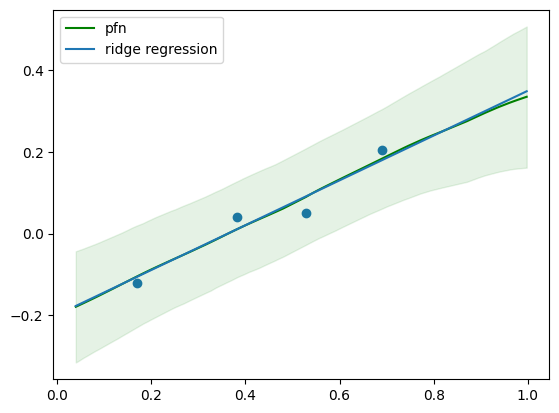

In [11]:
batch = sample_1D_prior_datasets(seq_len=100, hyperparameters=hps, batch_size=10)  # Sample some datasets to look at.
batch_index = 0
num_training_points = 4

train_x = batch.x[batch_index, :num_training_points]
train_y = batch.y[batch_index, :num_training_points]
test_x = batch.x[batch_index]

with torch.no_grad():
    logits = trained_model(train_x[None], train_y[None], test_x[None])

pred_means = trained_model.criterion.mean(logits)[0]        # extract mean
pred_confs = trained_model.criterion.quantile(logits)[0]    # extract quantiles/confidence bounds

# PFN results
plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x,0], pred_confs[...,0][order_test_x], pred_confs[...,1][order_test_x], alpha=.1, color='green')

# Ridge regression results
ridge_model = sklearn.linear_model.Ridge(alpha=(alpha/beta)**2)
ridge_model.fit(train_x,train_y)
plt.plot(test_x[order_test_x].squeeze(), ridge_model.predict(test_x[order_test_x]), label='ridge regression')
plt.legend()
plt.plot()

What we can observe is that PFNs provide **confidence bounds** in addition to point predictions, unlike ridge regression. This behavior arises naturally, without any additional modifications, because PFNs operate on a **discretized output distribution**, referred to as the **Riemann distribution**. The discretization is defined by a set of bins that are adapted to the training prior.

---

#### **Riemann Distribution and Uncertainty in PFNs**

<figure align="center">
    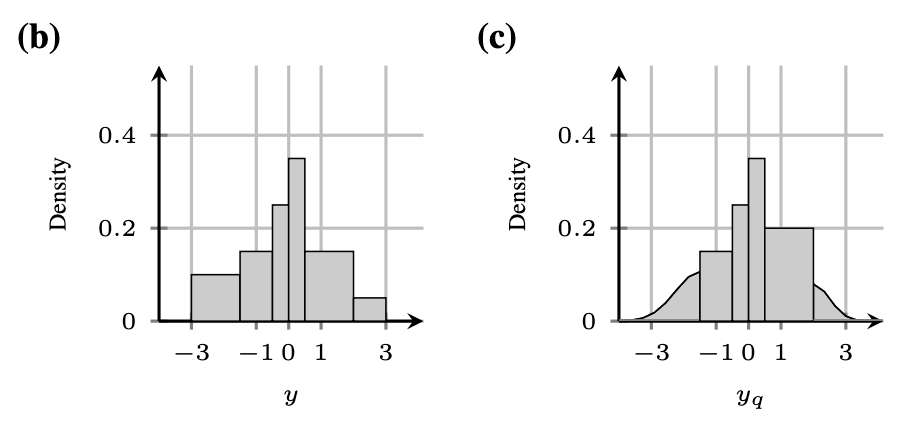
    <figcaption>
        Fig. 3. A visualisation of the Riemann distribution, (b)with and (c)without bounded support.
    </figcaption>
</figure>

Unlike ridge regression, PFNs directly output **predictive uncertainty**. This is because they do not predict a single scalar value; instead, they predict a discretized probability distribution, referred to in the PFN paper as a **Riemann distribution**.

The Riemann distribution is a **piecewise-constant approximation** of a continuous probability density. The output space is divided into a finite number of bins, and the model predicts the probability mass assigned to each bin. This transforms regression into a **classification-like problem over bins**, while still allowing recovery of a full predictive distribution.

- **Piecewise-Constant Output Distribution**

    The output space is partitioned by ordered bin boundaries

  $$b_0 < b_1 < \dots < b_K,$$

    stored in `trained_model.criterion.borders`. These boundaries are **learned from the training prior** and are therefore not arbitrary:
    - bins are placed where probability mass is likely to occur,
    - higher resolution is allocated to regions of high density.

    For a given test input, the PFN produces logits over bins. Applying a softmax,

  $$p_k = \text{softmax}(\text{logits})_k,$$

    yields the probability mass assigned to each interval $[b_{k-1}, b_k)$, where $p_k \ge 0$ and $\sum_{k=1}^K p_k = 1$.

    To visualize this distribution as a density, we divide by the bin widths

  $$w_k=b_k-b_{k-1},\qquad\hat{f}(y\in[b_{k-1},b_k))=\frac{p_k}{w_k}.$$

- **From Distribution to Point Prediction and Confidence Bounds**

    Because the PFN predicts a full distribution, we can extract point summaries such as the mode or mean, as well as quantiles that define confidence bounds. In contrast, ridge regression typically provides only a point estimate unless additional probabilistic assumptions are introduced.

For further details, see the discussion of the Riemann distribution in the PFN paper (https://arxiv.org/abs/2112.10510) or the implementation in `bar_distribution.py`.

<BarContainer object of 1000 artists>

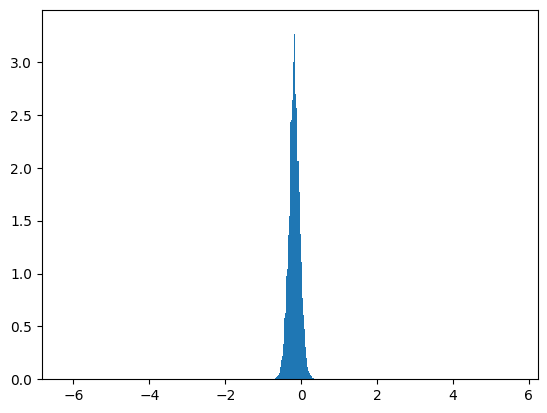

In [12]:
# Plot for the resulting histogram-like density for a single prediction
trained_model.criterion.mode(logits)                        # extract a mode/bin
probs_of_first_pred = logits[0,order_test_x[0]].softmax(0)  # gives p_k
borders = trained_model.criterion.borders
widths = borders[1:] - borders[:-1]                         # gives w_k
density_of_first_pred = probs_of_first_pred / widths        # gives a piecewise-constant density
plt.bar(borders[:-1].tolist(), density_of_first_pred.tolist(), width=widths, align='edge')

---

### **3.2 Sine Curve Regression**
To study PFN behavior in a nonlinear setting, we generate datasets from a sine-based prior and train a PFN on these prior-sampled datasets. On top of a linear structure, we add a nonlinear sine component.
$$f(x)=wx+b+s\sin(ax).$$

- **Prior**

    The linear coefficient is drawn from a Gaussian prior:
    $$w\sim N(0,\beta^2).$$

    For simplicity, we fix the remaining parameters:
    $$b=1,\quad a=20,\quad s=0.3,$$
    where $s$ controls the amplitude of the sinusoidal component.

- **Likelihood**

    Observations are generated with additive Gaussian noise:
    $$y\mid x\sim N(f(x), \alpha^2).$$

- **Data Generation**

    For dataset $i=1,\dots,K$ and samples $j=1,\dots,N$ for each dataset:
    $$x_{ij}\sim\text{Uniform}(0,1),$$
    $$w_i\sim N(0,\beta^2),\quad b_i=1,\quad a=20,\quad s=0.3,$$
    $$\epsilon_{ij}\sim N(0,\alpha^2),$$
    $$y_{ij}=x_{ij}^\top w_i+b_i+\epsilon_{ij}+s\sin(ax_{ij}).$$

> Exact Bayesian inference for this nonlinear model is analytically intractable. This experiment therefore highlights the ability of PFNs to learn an **amortized posterior predictive** directly from prior-sampled data, without explicitly inferring latent parameters.

##### 3.2.1 Sample from prior & Train PFN

init dist
Not using distributed
ALL: Using device cuda.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_sine_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, **kwargs)
), num_features=1, hyperparameters=None), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=256, min_single_eval_pos=0, max_seq_len=10, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_sine_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, **kwargs)
), num_features=1, hyperparameters=None), 'num_steps': 100, 'batch_shape_sampl

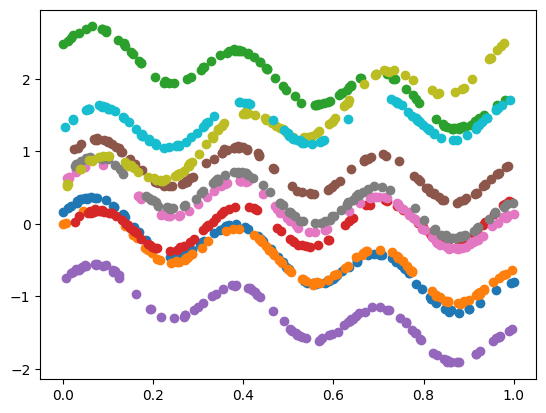

In [13]:
def sample_sine_prior_datasets(
    batch_size=10,
    seq_len=100,
    num_features=1,
    hyperparameters=None,
    **kwargs
):
    if hyperparameters is None:
        hyperparameters = {'a': 0.01, 'b': 1.0, 's': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))    # (K, F+1)
    bs = torch.ones(batch_size, seq_len, 1)                                                                     # (K, N, 1)

    xs = torch.rand(batch_size, seq_len, num_features)
    ys = torch.distributions.Normal(torch.einsum('knf, kf -> kn', torch.cat([xs, bs], 2), ws), hyperparameters['a']).sample()   # (K, N, F+1)∙(K, F+1) -> (K, N)
    ys += torch.sin(xs[...,0]*20) * hyperparameters['s']

    return Batch(x=xs, y=ys[...,None], target_y=ys[...,None])

batch = sample_sine_prior_datasets()
for dataset_index in range(len(batch.x)):
    plt.scatter(batch.x[dataset_index,:,0].numpy(), batch.y[dataset_index,:].numpy())

train_results_sine = train_a_pfn(sample_sine_prior_datasets, epochs=20) # Train!
trained_model_sine = train_results_sine['model']    # trained model

##### 3.2.2 Analysis of the performance of trained PFN
You can change the number of `batch_index` to see other examples.

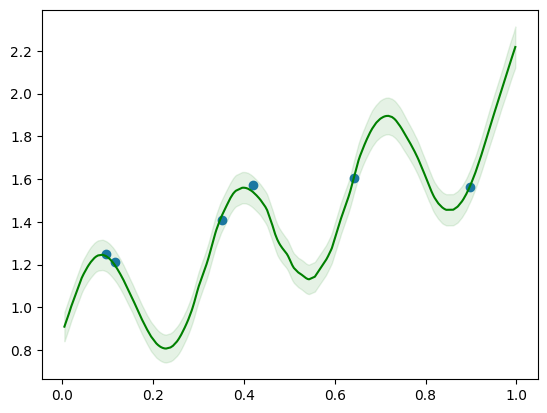

In [14]:
batch = sample_sine_prior_datasets(seq_len=300)
batch_index = 2
num_training_points = 6

train_x = batch.x[batch_index,:num_training_points]
train_y = batch.y[batch_index, :num_training_points]
test_x = batch.x[batch_index]

with torch.no_grad():
    logits = trained_model_sine(train_x[None], train_y[None], test_x[None])
pred_means = trained_model_sine.criterion.mean(logits)[0]
pred_confs = trained_model_sine.criterion.quantile(logits)[0]

plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x,0], pred_confs[..., 0][order_test_x], pred_confs[...,1][order_test_x], alpha=.1, color='green')

We can see that the predictions appear in a sine shape, too.

---

### 3.3 **Anti-Sine Regression**

Now consider a deliberately **misspecified setting**, where the data generating process lies outside the assumed prior family. Specifically, consider the function
$$f(x)=-\sin(x),$$
which is inconsistent with the sine structure encoded in the prior. In this regime, the data are not generated from the assumed prior. Nevertheless, PFNs still return predictions corresponding to the **closest explanation under the prior**, closely mirroring Bayesian inference under model misspecification.

- **Using `batch.target_y`**

    In all `sample_datasets` functions, two versions of the output are specified: `batch.y` and `batch.target_y`.  
    This distinction reflects how they are used during training:

    - `batch.y` provides **context information** to the PFN, representing noisy observations.
    - `batch.target_y` is used as the **supervision signal**, i.e., the quantity the transformer is trained to predict.

    This separation allows us to control whether the PFN is trained to fit noisy observations or to recover an underlying noise-free signal.

    Such a distinction is particularly important in settings like **Expected Improvement (EI)** in Bayesian optimization. EI is typically defined with respect to the **noise-free objective function**, rather than noisy observations, since noise can artificially inflate predictive uncertainty and distort the acquisition function.

- **Data Generation and Training Target**

    As in the previous sine example(3.2), datasets are generated by combining a linear-Gaussian component with a sinusoidal signal:
    $$y_{ij}=x_{ij}w_i+b_i+\epsilon_{ij}+s\sin(ax_{ij}),$$
    where
    $$w_i\sim N(0,\beta^2),\quad\epsilon_{ij}\sim N(0,\alpha^2),$$
    and the remaining parameters are fixed to
    $$b_i=1,\quad a=20,\quad s=0.3.$$

    The crucial difference in this experiment is the choice of training target. While `batch.y` contains the **noisy observations**, we define
    $$\texttt{target\_y}_{ij}=x_{ij}w_i+b_i,$$
    corresponding to the **noise-free mean function**, i.e., the center of the sine-modulated data.

    During training:
    - `batch.y` is used as context input to the PFN,
    - `batch.target_y` serves as the prediction target.

    This setup trains the PFN to recover the **central trend** of the data rather than the noise-corrupted observations themselves, leading to more stable and interpretable uncertainty estimates.

> This experiment demonstrates that PFNs can:
> 1. remain robust under prior mismatch, and  
> 2. flexibly adapt their predictive behavior through the choice of training targets, even in the presence of structured noise.

##### 3.3.1 Sample from prior & Train PFN

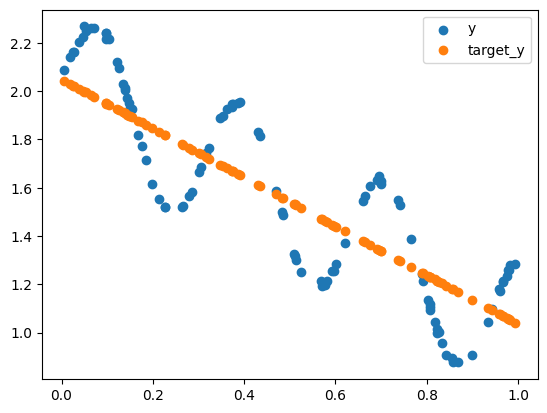

init dist
Not using distributed
ALL: Using device cuda.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_anti_sine_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, **kwargs)
), num_features=1, hyperparameters=None), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=64, min_single_eval_pos=0, max_seq_len=100, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.sample_anti_sine_prior_datasets (batch_size=10, seq_len=100, num_features=1, hyperparameters=None, **kwargs)
), num_features=1, hyperparameters=None), 'num_steps': 100, 'batch_s

In [15]:
def sample_anti_sine_prior_datasets(
    batch_size=10,
    seq_len=100,
    num_features=1,
    hyperparameters=None,
    **kwargs
):
    if hyperparameters is None:
        hyperparameters = {'a': 0.01, 'b': 1.0, 's': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))    # (K, F+1)
    bs = torch.ones(batch_size, seq_len, 1)                                                                     # (K, N, 1)

    xs = torch.rand(batch_size, seq_len, num_features)
    mean_ys = torch.einsum('knf, kf -> kn', torch.cat([xs, bs], 2), ws)
    ys = torch.distributions.Normal(mean_ys, hyperparameters['a']).sample()   # (K, N, F+1)∙(K, F+1) -> (K, N)
    ys += torch.sin(xs[...,0]*20) * hyperparameters['s']

    return Batch(x=xs, y=ys[...,None], target_y=mean_ys[...,None])

batch = sample_anti_sine_prior_datasets()

plt.scatter(batch.x[dataset_index,:,0].numpy(), batch.y[dataset_index].numpy(), label='y')
plt.scatter(batch.x[dataset_index,:,0].numpy(), batch.target_y[dataset_index].numpy(), label='target_y')
plt.legend()
plt.show()

train_results_anti_sine = train_a_pfn(sample_anti_sine_prior_datasets, batch_size=64, max_dataset_size=100)
trained_model_anti_sine = train_results_anti_sine['model']

If you see "nan" in the positional losses in the training log above that just means this particular `single_eval_pos` was not sampled.

##### 3.3.2 Analysis of the performance of trained PFN
You can change the number of `batch_index` to see other examples.

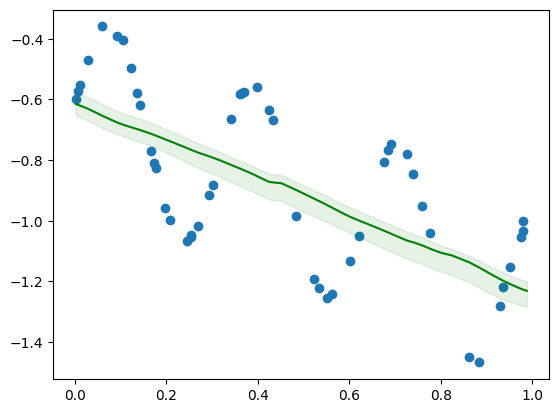

In [16]:
batch_index = 0
num_training_points = 50

train_x = batch.x[batch_index, :num_training_points]
train_y = batch.y[batch_index, :num_training_points]
test_x = batch.x[batch_index]

with torch.no_grad():
    logits = trained_model_anti_sine(train_x[None], train_y[None], test_x[None])

pred_means = trained_model_anti_sine.criterion.mean(logits)[0]
pred_confs = trained_model_anti_sine.criterion.quantile(logits)[0]

plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[..., 0][order_test_x], pred_confs[...,1][order_test_x], alpha=.1, color='green')

---

### 3.4 **Gaussian Process**
Instead of defining a prior over weights, we now consider a **function-space prior** in the form of a Gaussian Process (GP). Specifically, we use a GP with a radial basis function (RBF) kernel:
$$f\sim GP(0,k_{\text{RBF}}(x,x')).$$

- **RBF kernel**
    $$k_{\text{RBF}}(x, x')=\sigma_f^2\exp\!\left(-\frac{(x-x')^2}{2\ell^2}\right),$$
    - $\ell$ (`lengthscale`) : Controls the smoothness of the sampled functions.
    - $\sigma_f^2$ (`outputscale`) : Controls the overall function variance.

- **Likelihood**

    Observations are generated with additive Gaussian noise:
    $$y=f(x)+\epsilon,\qquad\epsilon\sim N(0,\sigma_n^2),$$
    $$y\mid f(x)\sim N(f(x),\sigma_n^2),$$
    where $\sigma_n^2$ (`noise`) corresponds to the **noise variance**.

- **Connection to PFNs**
    - Gaussian Processes admit **closed-form posterior predictive distributions**.
    - PFNs can be trained to approximate these posterior predictives in an **amortized inference** manner.
    - Changing the kernel (e.g., lengthscale or outputscale) corresponds to changing the **training prior** of the PFN.

These datasets are generated using a GP prior already implemented in the package and stored in the `priors` folder, which serves as a centralized location for reusable data-generating priors.

After sampling a small batch of GP datasets for visualization, a PFN is trained using the same GP prior. During training, the PFN observes context points sampled from GP functions and is optimized to predict function values at new input locations. Because GP posterior predictives are analytically available, this setting provides a clean and interpretable benchmark:  
the PFN can be directly compared against the exact Bayesian posterior predictive of the GP under the same prior.

Finally, since the PFN outputs a full predictive distribution, it can be used to compute **Expected Improvement (EI)** and other acquisition functions, enabling Bayesian optimization in a GP-like setting without performing explicit GP inference or kernel matrix inversion at test time.

A live demo illustrating this GP-based PFN behavior can be found at:  
https://huggingface.co/spaces/samuelinferences/transformers-can-do-bayesian-inference

##### 3.4.1 Sample from Prior & Train PFN

init dist
Not using distributed
ALL: Using device cuda.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<pfns.priors.fast_gp.get_batch (batch_size, seq_len, num_features, device='cuda:0', hyperparameters=None, equidistant_x=False, fix_x=None, **kwargs)
), num_features=1, hyperparameters={'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.1}), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=256, min_single_eval_pos=0, max_seq_len=10, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<pfns.priors.fast_gp.get_batch (batch_size, seq_len, num_features, device='cuda:0', hyperparameters=None

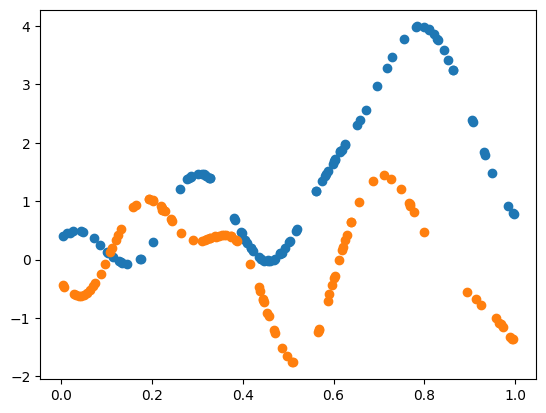

In [17]:
batch = get_batch_for_gp(batch_size=2, seq_len=100, num_features=1, hyperparameters={"noise": 1e-4, "outputscale": 1., "lengthscale": 0.1})
for dataset_index in range(len(batch.x)):
    plt.scatter(batch.x[dataset_index,:,0].cpu().numpy(), batch.y[dataset_index,:].cpu().numpy())

training_output_gp = train_a_pfn(get_batch_for_gp, hps={"noise": 1e-4, "outputscale": 1., "lengthscale": 0.1})
trained_model_gp = training_output_gp['model']

##### 3.4.2 Analysis of the performance of trained PFN
You can change the number of `batch_index` to see other examples.

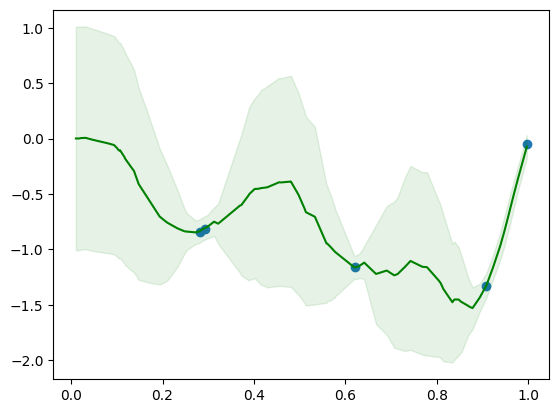

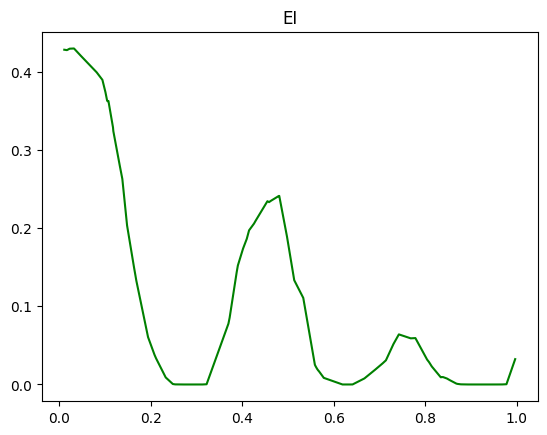

In [18]:
batch = get_batch_for_gp(batch_size=2, seq_len=100, num_features=1, hyperparameters={"noise": 1e-4, "outputscale": 1., "lengthscale": 0.1})
batch_index = 0
num_training_points = 5

train_x = batch.x[batch_index, :num_training_points].cpu()
train_y = batch.y[batch_index, :num_training_points].cpu()
test_x = batch.x[batch_index].cpu()

with torch.no_grad():
    logits = trained_model_gp(train_x[None], train_y[None], test_x[None])

pred_means = trained_model_gp.criterion.mean(logits)[0]
pred_confs = trained_model_gp.criterion.quantile(logits)[0]

plt.scatter(train_x[...,0],train_y)
order_test_x = test_x[...,0].argsort()
plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[..., 0][order_test_x], pred_confs[...,1][order_test_x], alpha=.1, color='green')

pred_ei = trained_model_gp.criterion.ei(logits, best_f=max(train_y))    # Calculate EI
plt.figure()
plt.title('EI')
plt.plot(test_x[order_test_x, ..., 0], pred_ei[0,order_test_x], color='green', label='ei')
plt.show()

##### In summary, PFNs can be viewed as compiled Bayesian inference: a reusable model that approximates posterior predictives under a specified prior, providing uncertainty-aware predictions even in nonlinear and misspecified settings.